# ML Classification of Electrophysiological Data

<img src='images/Spiking_traces.PNG' alt='Drawing' style="width: 500px;"/>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Datasets/intrinsic_cluster_analysis.csv")
data.head(5)

,Unnamed: 0,Delay,Rheobase,Rin,tau,Max,Unnamed: 6
0,1,27.90,75.8,258.000,12.3000,143.0,NaN
1,2,331.90,44.8,412.000,13.4708,66.0,NaN
2,3,134.80,36.0,536.500,23.9807,64.0,NaN
3,4,176.80,26.6,692.000,27.1597,25.0,NaN
4,5,41.42,104.0,318.632,13.0589,30.0,NaN


In [3]:
#Drop NaN and index column, add putative cell type columns

cleaned_data = data.drop(['Unnamed: 0'], axis = 1) #drop unwanted columns
cleaned_data.rename(columns={'Unnamed: 6':'Cell Type'}, inplace=True) #Rename Column with putative cell type
cleaned_data.loc[0:16, 'Cell Type'] = 'Cell Type 1'
cleaned_data.loc[17:45, 'Cell Type'] = 'Cell Type 2'
cleaned_data.loc[46:, 'Cell Type'] = 'Cells to classify'
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Delay      67 non-null     float64
 1   Rheobase   67 non-null     float64
 2   Rin        67 non-null     float64
 3   tau        67 non-null     float64
 4   Max        67 non-null     float64
 5   Cell Type  67 non-null     object 
dtypes: float64(5), object(1)
memory usage: 3.3+ KB


In [4]:
cleaned_data.rename(columns={'Delay':'Latency to 1st AP (ms)', 'Rheobase':'Rheobase (pA)', 'Rin': 'Input Resistance (MOhms)', 'Max': 'Max Firing (# of APs)', 'tau' : 'Decay Tau (ms)'}, inplace=True)

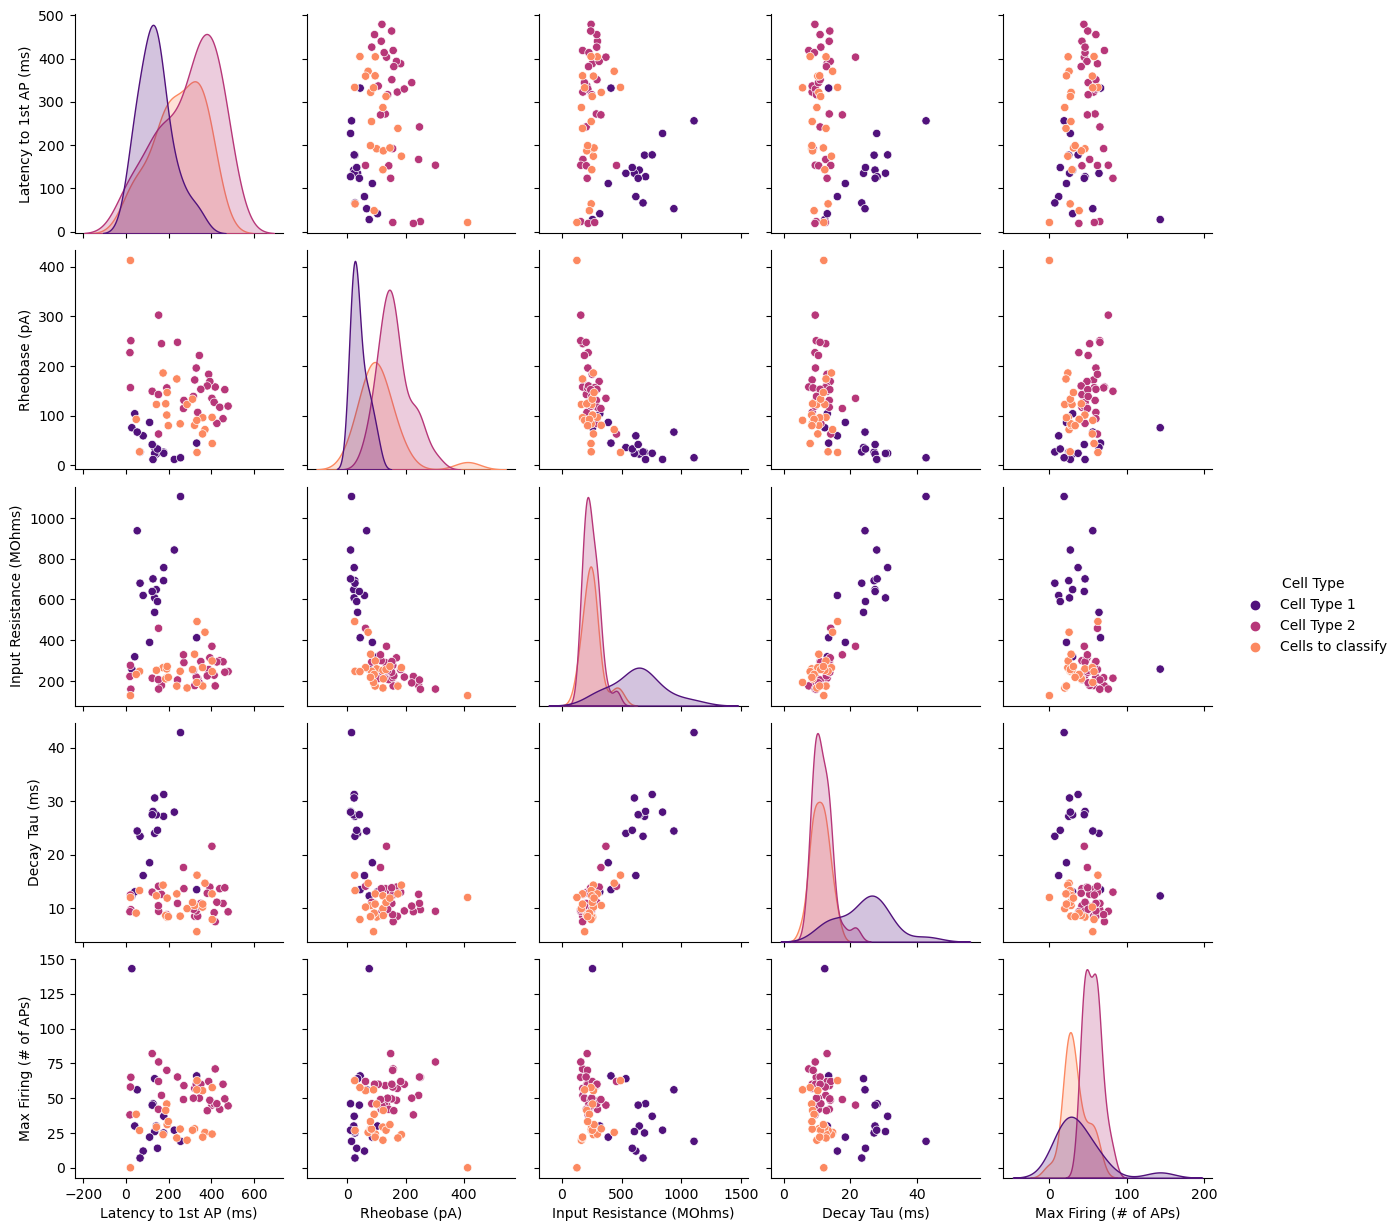

In [5]:
#Quick Pair plot to look at overall data distribution

pairplot_kde = sns.pairplot(cleaned_data, diag_kind="kde", hue='Cell Type', palette="magma")
plt.show()

In [6]:
# helper boxplot function to visualise outliers data
def show_boxplot(df):
    plt.rcParams['figure.figsize'] = [10,6]
    sns.boxplot(data = df, orient="v", palette='mako')
    plt.title("Data Distribution", fontsize = 16)
    plt.ylabel("Range", fontweight = 'bold')
    plt.xlabel("Attributes", fontweight = 'bold')

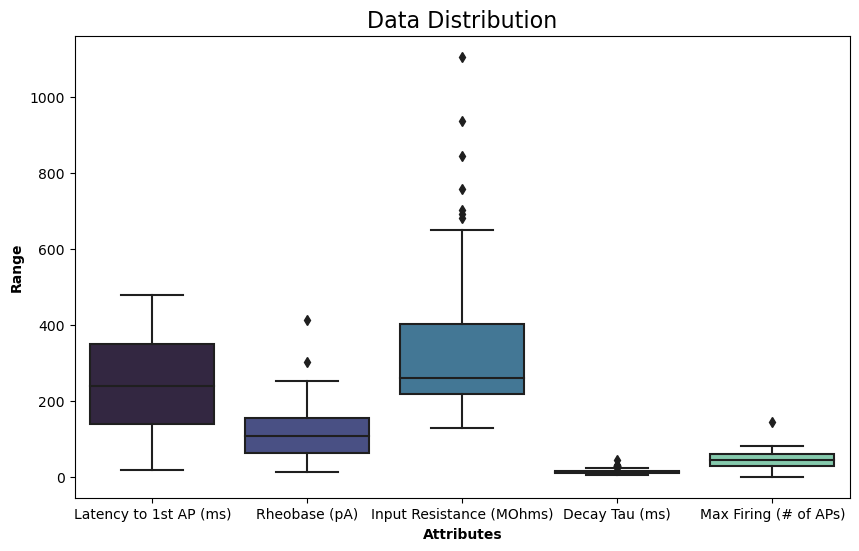

In [7]:
show_boxplot(cleaned_data) #visualise data distribution

   Latency to 1st AP (ms)  Rheobase (pA)  Input Resistance (MOhms)  \
0                   27.90           75.8                   258.000   
1                  331.90           44.8                   412.000   
2                  134.80           36.0                   536.500   
3                  176.80           26.6                   692.000   
4                   41.42          104.0                   318.632   

   Decay Tau (ms)  Max Firing (# of APs)  
0         12.3000                  143.0  
1         13.4708                   66.0  
2         23.9807                   64.0  
3         27.1597                   25.0  
4         13.0589                   30.0  
Scaled data shape is (67, 5)


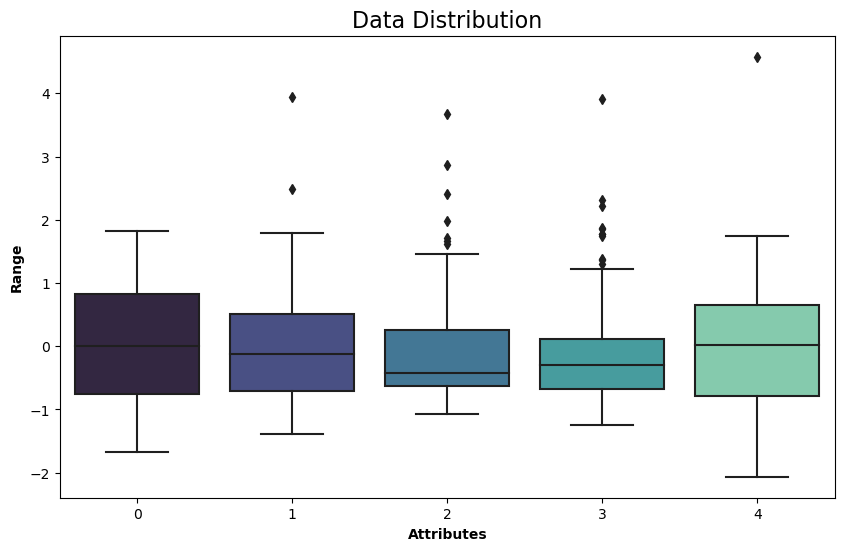

In [8]:
from sklearn.preprocessing import StandardScaler

data_scaler = StandardScaler()

df = pd.DataFrame(cleaned_data.iloc[:,:5]) #dropping column cell type as scaling does not work with object dtype
print (df.head())

scaled_data = data_scaler.fit_transform(df)
print ('Scaled data shape is',scaled_data.shape) #The shape of the data remains the same as the cleaned data (46 rows, 5 columns) because the scaling does not affect data variance or shape.

show_boxplot(scaled_data)

In [9]:
#Re-append 'putative cell type' column onto data frame
df_scaled_data = pd.DataFrame(scaled_data)
df_scaled_data['Cell Type'] = cleaned_data['Cell Type']
df_scaled_data.rename(columns={0:' Latency to 1st AP (ms)', 1:'Rheobase (pA)', 2:'Input Resistance (MOhms)', 3:'Decay Tau (ms)', 4:'Max Firing (# of APs)'}, inplace=True) 
df_scaled_data.head()
df_scaled_data.head()

,Latency to 1st AP (ms),Rheobase (pA),Input Resistance (MOhms),Decay Tau (ms),Max Firing (# of APs),Cell Type
0,-1.597525,-0.532602,-0.435153,-0.318385,4.578711,Cell Type 1
1,0.701864,-0.944776,0.312130,-0.156236,1.002232,Cell Type 1
2,-0.788957,-1.061780,0.916265,1.299325,0.909337,Cell Type 1
3,-0.471278,-1.186761,1.670826,1.739598,-0.902127,Cell Type 1
4,-1.495263,-0.157658,-0.140937,-0.213282,-0.669888,Cell Type 1


## Classifier 1: Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

df_scaled_data_train = df_scaled_data.iloc[:46,:]

X = df_scaled_data_train.drop(['Cell Type'], axis=1)
y = df_scaled_data_train['Cell Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### Assessing model performance
- Accuracy Score 
- Area Under the Receiver Operating Characteristic Curve (ROC AUC) 
- Confusion Matrix 
- Classification Report

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

train_acc = accuracy_score(y_train, model.predict(X_train))
print (f'Training accuracy score is {train_acc}')
test_acc = accuracy_score(y_test, model.predict(X_test))
print (f'Test accuracy score is {test_acc}')

logistic_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
print(f'Training ROC AUC score is: {logistic_roc_train}')
logistic_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f'Test ROC AUC score is: {logistic_roc_test}') #while it looks like the model has over fitted with the test ROC score, this is probably due to the low n numbers

Training accuracy score is 0.9411764705882353
Test accuracy score is 0.9166666666666666
Training ROC AUC score is: 0.9924242424242424
Test ROC AUC score is: 1.0


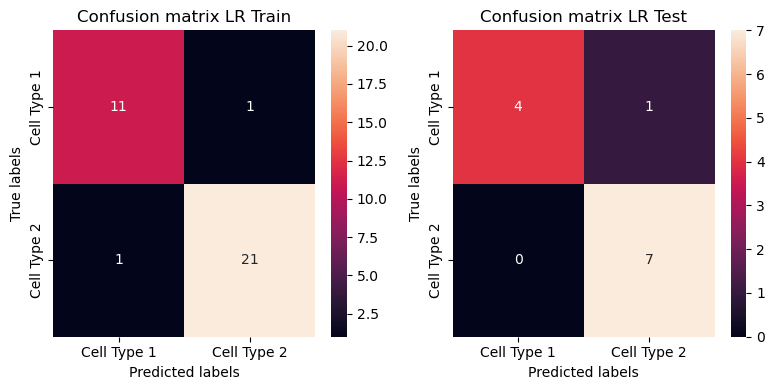

In [12]:
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, model.predict(X_train))
cm_test = confusion_matrix(y_test, model.predict(X_test))

fig, axs = plt.subplots(1, 2, figsize=(8,4))

sns.heatmap(cm_train, xticklabels=['Cell Type 1', 'Cell Type 2'], yticklabels=['Cell Type 1', 'Cell Type 2'], annot=True, fmt='d', ax=axs[0])
axs[0].set_title("Confusion matrix LR Train")
sns.heatmap(cm_test, xticklabels=['Cell Type 1', 'Cell Type 2'], yticklabels=['Cell Type 1', 'Cell Type 2'], annot=True, fmt='d', ax=axs[1])
axs[1].set_title("Confusion matrix LR Test")

for ax in axs.flat:
        ax.set(xlabel='Predicted labels', ylabel='True labels')
        ax.label_outer()
plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import classification_report
y_train_pred=model.predict(X_train)
print(f'\033[1m Training calssification report: \n\033[0m{classification_report(y_train, y_train_pred)}')
y_test_pred=model.predict(X_test)
print(f'\033[1m Test calssification report: \n\033[0m{classification_report(y_test, y_test_pred)}')

 Training calssification report: 
              precision    recall  f1-score   support

 Cell Type 1       0.92      0.92      0.92        12
 Cell Type 2       0.95      0.95      0.95        22

    accuracy                           0.94        34
   macro avg       0.94      0.94      0.94        34
weighted avg       0.94      0.94      0.94        34

 Test calssification report: 
              precision    recall  f1-score   support

 Cell Type 1       1.00      0.80      0.89         5
 Cell Type 2       0.88      1.00      0.93         7

    accuracy                           0.92        12
   macro avg       0.94      0.90      0.91        12
weighted avg       0.93      0.92      0.91        12



#### Use shapley values to infer feature importance

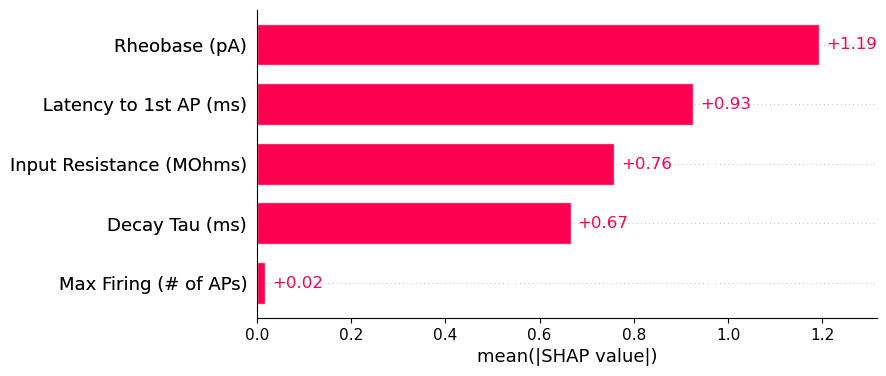

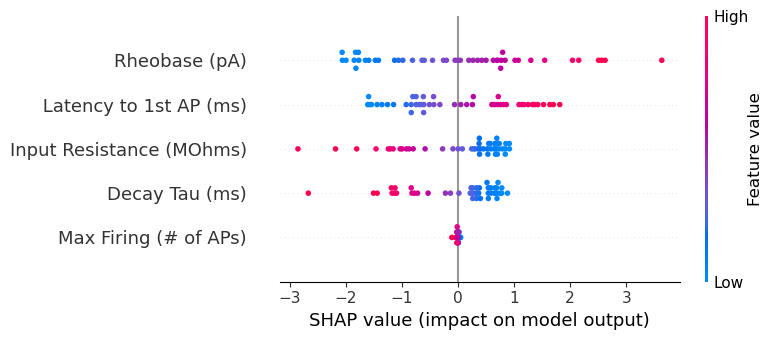

In [18]:
import shap
LR_shap = model.fit(X, y)

explainer = shap.Explainer(LR_shap, X)
shap_values = explainer(X)

shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X[0:1000])

### Running the logistic regression such that the class values of 'Cells to classify' are now predicted

In [15]:
X_LR = df_scaled_data.drop(['Cell Type'],axis = 1)
LR = model.predict(X_LR)

cleaned_data = pd.concat ([cleaned_data, pd.DataFrame(LR, columns =['LR_Cell Type'])], axis=1) #append column onto main dataframe
cleaned_data.head(5)

,Latency to 1st AP (ms),Rheobase (pA),Input Resistance (MOhms),Decay Tau (ms),Max Firing (# of APs),Cell Type,LR_Cell Type
0,27.90,75.8,258.000,12.3000,143.0,Cell Type 1,Cell Type 1
1,331.90,44.8,412.000,13.4708,66.0,Cell Type 1,Cell Type 2
2,134.80,36.0,536.500,23.9807,64.0,Cell Type 1,Cell Type 1
3,176.80,26.6,692.000,27.1597,25.0,Cell Type 1,Cell Type 1
4,41.42,104.0,318.632,13.0589,30.0,Cell Type 1,Cell Type 1


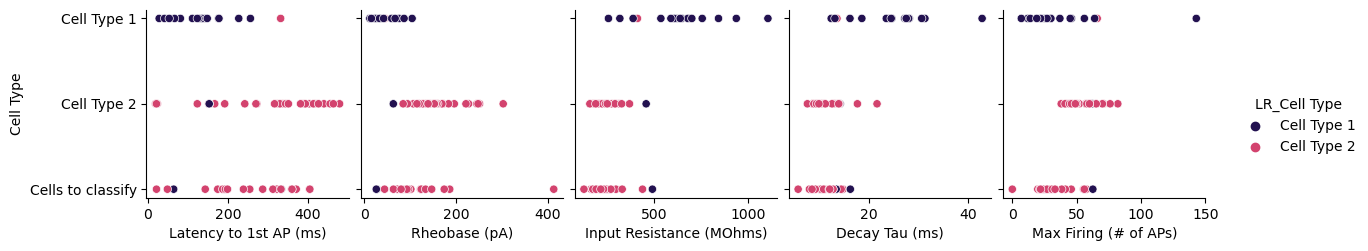

In [16]:
sns.pairplot(
    cleaned_data, 
    x_vars=['Latency to 1st AP (ms)', 'Rheobase (pA)', 'Input Resistance (MOhms)', 'Decay Tau (ms)', 'Max Firing (# of APs)'],
    y_vars=['Cell Type'],
    diag_kind="kde", 
    hue='LR_Cell Type', 
    palette= {'Cell Type 1':'#221150', 'Cell Type 2':'#d3436e'},
)
plt.show()